In [157]:
import numpy as np
import igl
from scipy.spatial.transform import Rotation
import ipywidgets as iw
import time
import scipy.sparse as sp
import triangle as tr
import matplotlib.pyplot as plt
import os
import sys
import meshplot as mp
import collections

In [159]:
#import point cloud and cage
v, f = igl.read_triangle_mesh('data/woody-hi.off')
cage = np.load('data/woody_cage.npy')
#Scale and shift the point cloud and cage
#v[:, 2] = 0
v = v - v.min(axis=0)
v = v /v.max()

In [160]:
#function to check if a point v lies on the line segment ab
def on_edge(a, b, v):
    ab = b - a
    av = v - a
    ab_ = np.linalg.norm(ab)
    av_ = np.linalg.norm(av)
    cos = np.dot(ab, av) / (ab_ * av_)
    if np.isclose(1, cos) and av_ <= ab_:
        return True
    return False

In [161]:
#function which returns all the points generated by the triangle mess that lie on the boundary but 
#are not the cage vertices
def get_on_edge(cage, cage_v, cage_join):
    till_cage  =cage_v.shape[0] - cage.shape[0]
    onEdge = collections.defaultdict(list)
    count = 0
    to_remove_map = {}
    boundary_vertices = []
    for edge in cage_join:
        for i, vertex in enumerate(cage_v[:till_cage]):
            if on_edge(cage[edge[0]][:2], cage[edge[1]][:2], vertex):
                onEdge[till_cage + edge[0]].append([i, till_cage + edge[1]])
                onEdge[till_cage + edge[1]].append([i, till_cage + edge[0]])
                boundary_vertices.append(i)
                to_remove_map[i] = count
                count += 1
    return onEdge, np.array(boundary_vertices), to_remove_map

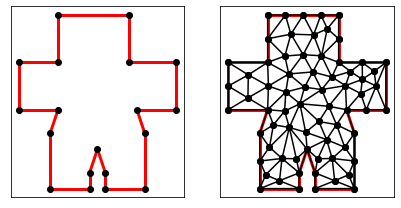

In [162]:
#Creating the triangle mesh
cage_join = (np.vstack((np.arange(cage.shape[0]), np.arange(cage.shape[0])+1))).T
cage_join[-1,-1] = 0
num_pure_cage = cage.shape[0]
cage_dict = dict(vertices=cage[:,:2], segments=cage_join, segment_markers=np.ones(cage.shape[0]))
cage_tri = tr.triangulate(cage_dict, 'pqa0.01')

tr.compare(plt, cage_dict, cage_tri)
plt.show()

cage_v = cage_tri['vertices']
cage_f = cage_tri['triangles']
cage_markers = cage_tri['vertex_markers']


In [163]:
def reorder(v, f, cage):
    cage_len = cage.shape[0]
    v_order = np.append(np.arange(cage_len, v.shape[0]), np.arange(cage_len))
    map_ = dict(zip(v_order, np.arange(v.shape[0])))
    mapp = lambda t: map_[t]
    mapping = np.vectorize(mapp)
    return v[v_order], mapping(f)
    

In [165]:
print("Number of vertices:", v.shape)
print("Number of faces:", f.shape)
print("Number of vertices in the cage mesh:",cage_v.shape)
print("Number of faces in the cage mesh:",cage_f.shape)

Number of vertices: (2642, 3)
Number of faces: (5040, 3)
Number of vertices in the cage mesh: (69, 2)
Number of faces in the cage mesh: (107, 3)


In [174]:
#functions to check if a point lies inside a traingle: Same Side method
def orient(A, B, C):
    AB = B - A
    AC = C - A
    cross = AB[0] * AC[1] - AB[1] * AC[0]
    if cross > 0:
        return 1
    else:
        return -1

def inside_triangle(P, A, B, C):
    turns = orient(A, B, P) + orient(B, C, P) + orient(C, A, P)
    if abs(turns) == 3:
        return True
    else:
        return False


In [175]:
def assign_tri_to_vertices(cage_v, cage_f, v): #function to assign points to a triangle
    vertex_to_triangle = np.zeros(v.shape[0], dtype = 'int')
    barycentric_coef = np.zeros((v.shape[0], 3))
    for i, vertex in enumerate(v):
        for j, tri, in enumerate(cage_f):
            A = cage_v[tri[0]]
            B = cage_v[tri[1]]
            C = cage_v[tri[2]]
            if inside_triangle(vertex[:2], A, B, C):
                vertex_to_triangle[i] = j #assign triangle to vertex
                A = np.append(A, [0])
                B = np.append(B, [0])
                C = np.append(C, [0])
#                 A_ = np.vstack((A, B, C)).T
                #print(vertex.shape, A.shape, B.shape, C.shape)
                #print(igl.barycentric_coordinates_tri(vertex.reshape(1, -1), A.reshape(1, -1), B.reshape(1, -1), C.reshape(1, -1)))
                #barycentric_coef[i, :] = np.linalg.lstsq(A_, vertex, rcond=None)[0] #TODO: normalize maybe
                barycentric_coef[i, :] =igl.barycentric_coordinates_tri(vertex.reshape(1, -1), A.reshape(1, -1), B.reshape(1, -1), C.reshape(1, -1))
                break
    return vertex_to_triangle, barycentric_coef


In [176]:
def section_value(a, v, b): #returns the barycentric coef for vertices on boundary edges
    ab = b - a
    av = v - a
    #print(np.linalg.norm(av), np.linalg.norm(ab))
    #print(np.linalg.norm(av)/ np.linalg.norm(ab))
    return np.linalg.norm(av) / np.linalg.norm(ab)

In [177]:
def get_triangle_coord(deformed_cage, bary_coef_tri): #returns the new co-ordinates of the mesh after deforming
    print(bary_coef_tri.shape, deformed_cage.shape)
    deformed_mesh = np.dot(bary_coef_tri, deformed_cage)
    return deformed_mesh

In [178]:
def getA(A, f, c): #matrix slicing for calculating Aff and Afc for laplacian
    return A[f][:, f], A[f][:, c]

    
def getV(v, X_c, f, c): #reorder the laplacian solution
    v_ = np.zeros(v.shape[0] + X_c.shape[0])
    v_[f] = v
    v_[c] = X_c
    return v_

In [179]:
%time
#Apply laplacian to obtain correct barycentric coeff for the triangle mesh
bary_coef_tri = np.zeros((cage_v.shape[0], cage.shape[0]))
cage_v_r, cage_f_r = reorder(cage_v, cage_f, cage) #reorder the vertices and faces to make slicing easy :ONLY DO THIS ONCE
onEdge, to_remove, to_remove_map = get_on_edge(cage, cage_v_r, cage_join)
L_cotan = igl.cotmatrix(cage_v_r, cage_f_r) # Cotangent Laplacian Matrix
M = igl.massmatrix(cage_v_r, cage_f_r, igl.MASSMATRIX_TYPE_BARYCENTRIC) #Digonal mass matrix
M_ = sp.diags(1 / M.diagonal())
A = M_ * L_cotan #the laplacian
till_cage = cage_v.shape[0] - cage.shape[0]

for i in range(till_cage, till_cage + cage.shape[0]): #traverse through all boundary points
    X_c = np.zeros(cage.shape[0] + to_remove.shape[0])
    X_c[i - till_cage] = 1 #choosing the ith cage point to be 1
    for j in range(len(onEdge[i])):
        pos = onEdge[i][j][0]
        X_c[cage.shape[0] + to_remove_map[pos]] = section_value(cage_v_r[onEdge[i][j][1]], cage_v_r[pos],  cage_v_r[i])
    c = np.append(np.arange(cage.shape[0]) + till_cage, to_remove)
    c= np.array(c, dtype = 'int')
    f_ = np.delete(np.arange(cage_v.shape[0]), c)
    A_ff, A_fc = getA(A, f_, c)
    v_ = sp.linalg.spsolve(A_ff, -A_fc @ X_c)
    bary_coef_tri[:, i-till_cage] = getV(v_, X_c, f_, c)

vertex_to_triangle, barycentric_coef= assign_tri_to_vertices(get_triangle_coord(cage, bary_coef_tri)[:, :2], cage_f_r, v) 

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
(69, 19) (19, 3)


In [180]:
np.sum(bary_coef_tri, axis = 1) #To verify that the sum of the harmonic weights is 1 for each cage point

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [181]:
#after applying laplacian 
p = mp.plot(cage_v_r, cage_f_r, shading={"wireframe": True, "wire_width": 0.1,"wire_color": "black"})
cage_v_l = get_triangle_coord(cage, bary_coef_tri)
p.add_mesh(cage_v_l, cage_f_r, shading={"wireframe": True, "wire_width": 2, "wire_color": "blue"})
p.add_points(cage_v_l, shading={"point_color": "red", "point_size": 0.5 })
p_ = mp.plot(cage_v_l, cage_f_r, shading={"wireframe": True, "wire_width": 0.5,"wire_color": "black"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4499999…

(69, 19) (19, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4499999…

In [182]:
#Try to animate using assignment 5 widget
cage_copy = cage.copy() # take of copy of the cage mesh so we can update them
pos_f_saver = np.zeros((cage.shape[0], 3))
z = 0.0
def pos_f(s,x,y):
    if len(s) > 0: #if I select atleast 1 point from the list
        v_slice = cage[s, : ] + np.array([[x,y,z]])
        cage_copy[s, :] = v_slice
        for s_ in np.array(s):
            pos_f_saver[s_] = [x,y,z]
        t0 = time.time()
        v_deformed = pos_f.deformer(cage_copy)
        p.reset()
        p.add_mesh(v_deformed, cage_f_r, shading={"wireframe": True, "point_color": "green", "point_size": 0.5 })
        p.add_points(cage_copy, shading={"point_color": "red", "point_size": 0.5 })
        #p.update_object(vertices = v_deformed)
        t1 = time.time()
        print('FPS', 1/(t1 - t0))
        
def widgets_wrapper():
    segment_widget = iw.SelectMultiple(
                            options=np.arange(cage.shape[0]),
                            rows=10,
                            description="Cage Vertices")
    translate_widget = {i:iw.FloatSlider(min=-1, max=1, value=0, step=0.01) 
                        for i in 'xy'}

    def update_seg(*args):
        (translate_widget['x'].value, translate_widget['y'].value, z) = pos_f_saver[segment_widget.value[0]]
    segment_widget.observe(update_seg, 'value')
    widgets_dict = dict(s=segment_widget)
    widgets_dict.update(translate_widget)
    return widgets_dict


def position_deformer(deformed_cage):
    '''Fill in this function to change positions''' 
    deformed_mesh = np.dot(bary_coef_tri, deformed_cage)
    return deformed_mesh 
''' (Optional) Register this function to perform interactive deformation
pos_f.deformer = position_deformer
'''
pos_f.deformer = position_deformer

In [183]:
#p = mp.plot(v, f)
p = mp.plot(cage_v_r, cage_f_r, shading={"wireframe": True, "point_color": "green", "point_size": 0.5 })
p.add_points(cage, shading={"point_color": "red", "point_size": 0.5 })
iw.interact(pos_f,
            **widgets_wrapper())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4499999…

interactive(children=(SelectMultiple(description='Cage Vertices', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1…

<function __main__.pos_f(s, x, y)>

In [184]:
#This function is for deforming the character vertices using the deformed cage and barycentric coefficients as input
def get_deformed_vertices(barycentric_coef, cage_deformed, cage_f, vertex_to_triangle):
    cage_deformed = np.hstack((cage_deformed, np.zeros((cage_deformed.shape[0], 1))))
    barycentric_coef = np.stack(barycentric_coef[:, :, None], 0)
    i = 0
    triangle_for_vertex = cage_f[vertex_to_triangle]
    cage_deformed_v = np.stack((cage_deformed[triangle_for_vertex[:, 0]],
                    cage_deformed[triangle_for_vertex[:, 1]],
                    cage_deformed[triangle_for_vertex[:, 2]]), axis = 1)
    print(barycentric_coef.shape, cage_deformed.shape, vertex_to_triangle.shape, triangle_for_vertex.shape, cage_deformed_v.shape)
    cage_deformed_v = np.einsum("ijk->ikj", cage_deformed_v)
    v_deformed = np.einsum("ijk,ikl->ijl", cage_deformed_v, barycentric_coef)
    return v_deformed

In [185]:
#Try to animate using assignment 5 widget
cage_copy = cage.copy() # take of copy of the cage mesh so we can update them
v_copy = v.copy()
pos_f_saver = np.zeros((cage.shape[0], 3))
z = 0.0
def pos_f(s,x,y):
    if len(s) > 0: #if I select atleast 1 point from the list
        v_slice = cage[s, : ] + np.array([[x,y,z]])
        cage_copy[s, :] = v_slice
        for s_ in np.array(s):
            pos_f_saver[s_] = [x,y,z]
        t0 = time.time()
        v_deformed, deformed_mesh  = pos_f.deformer(cage_copy)
        #p.reset()
        #p.add_mesh(v_deformed, cage_f_r, shading={"wireframe": True, "point_color": "green", "point_size": 0.5 })
        p.update_object(oid = 0, vertices = deformed_mesh)
        p.update_object(oid = 1, vertices = v_deformed)
        t1 = time.time()
        print('FPS', 1/(t1 - t0))
        
def widgets_wrapper():
    segment_widget = iw.SelectMultiple(
                            options=np.arange(cage.shape[0]),
                            rows=10,
                            description="Cage Vertices")
    translate_widget = {i:iw.FloatSlider(min=-1, max=1, value=0, step=0.01) 
                        for i in 'xy'}

    def update_seg(*args):
        (translate_widget['x'].value, translate_widget['y'].value, z) = pos_f_saver[segment_widget.value[0]]
    segment_widget.observe(update_seg, 'value')
    widgets_dict = dict(s=segment_widget)
    widgets_dict.update(translate_widget)
    return widgets_dict


def position_deformer(deformed_cage):
    '''Fill in this function to change positions''' 
    deformed_mesh = np.dot(bary_coef_tri, deformed_cage)
    
    v_deformed= get_deformed_vertices(barycentric_coef, deformed_mesh[:, :2], cage_f_r, vertex_to_triangle)
    v_deformed= np.squeeze(v_deformed)
    return v_deformed, deformed_mesh

pos_f.deformer = position_deformer

In [186]:
# ## Widget UI

p = mp.plot(cage_v_r, cage_f_r, c = np.array([0.5, 1, 1]))
#p = mp.plot(v, f, shading={"wireframe": False, "point_color": "green", "point_size": 0.5 })
#p_ = mp.plot(cage_v_r, cage_f_r, shading={"wireframe": True, "point_color": "green", "point_size": 0.5 })
p.add_mesh(v, f, c = np.array([0.0, 0.3, 1]))
iw.interact(pos_f,
            **widgets_wrapper())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4499999…

interactive(children=(SelectMultiple(description='Cage Vertices', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1…

<function __main__.pos_f(s, x, y)>